In [8]:
#Install Required Libraries
#pip install opencv-python matplotlib
#pip install tensorflow tensorflow-hub opencv-python matplotlib
#pip install tensorflow scikit-learn opencv-python gTTS


In [1]:
# Import Libraries
import os
import random
import requests
import torch
from PIL import Image
from torch.utils.data import DataLoader
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch.nn.functional as F



from pathlib import Path

In [ ]:
# Super Gradients Imports
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training import Trainer
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloE
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, 
    coco_detection_yolo_format_val
)
from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)



ImportError: cannot import name 'DEFAULT_YOLO_TRANSFORM' from 'super_gradients.training.transforms' (c:\Users\hanna\anaconda3\envs\tf3\lib\site-packages\super_gradients\training\transforms\__init__.py)

3.7.1


In [ ]:
#  Simple configuration class for creating the data set
class config:
    
    # Trainer params
    CHECKPOINT_DIR = './.ipynb_checkpoints' # Saves checkpoints

    EXPERIMENT_NAME = 'race_number' # Name of the experiment
    
    # Dataset params
    DATA_DIR = './input' # The data directory
    
    # Training set
    TRAIN_IMAGES_DIR =  './train_images' # Train images folder
    TRAIN_LABELS_DIR = "./train_labels" # Train labels folder

    # Validation
    VAL_IMAGES_DIR = './val_images' # Validation images folder
    VAL_LABELS_DIR = './val_labels' # Validation labels folder (array of points)
    
    # Test set
    TEST_IMAGES_DIR = './test_images' #child dir of DATA_DIR where test images are
    TEST_LABELS_DIR = './test_labels' #child dir of DATA_DIR where test labels are (array of points)

    CLASSES = ['free_parking_space','not_free_parking_space','partially_free_parking_space']
    NUM_CLASSES = len(CLASSES)

    # Dataloader params
    DATALOADER_PARAMS={
    'batch_size': 4,
    'num_workers': 2
    }

    # Model params
    MODEL_NAME = "yolo_nas_l"
    CHECKPOINT_PATH = "model_checkpoints/hub/checkpoints/yolo_nas_l_coco.pth"



# Load your YOLO-NAS model manually with your checkpoint path
model = models.get(
    "yolo_nas_l",
    num_classes=config.NUM_CLASSES,
    checkpoint_path="model_checkpoints/hub/checkpoints/yolo_nas_l_coco.pth",
    load_backbone=True

)




[2025-04-29 01:32:33] INFO - checkpoint_utils.py - Successfully loaded model's backbone weights from model_checkpoints/hub/checkpoints/yolo_nas_l_coco.pth checkpoint.


In [7]:
# Test Our model with dummy data

dummy_input = torch.randn(1, 3, 416, 416)  # assuming input is (batch_size, channels, height, width)
dummy_target = torch.zeros(1, 80, 416, 416)  # Adjust based on your dataset
output = model(dummy_input)

print("Model output:", output)




Model output: ((tensor([[[-59.4491, -59.7850,  74.4050,  65.5669],
         [-53.1315, -56.5372,  82.4974,  69.0362],
         [-48.2364, -57.8004,  86.9511,  69.7586],
         ...,
         [ 70.0213, 138.9377, 579.7744, 640.7522],
         [132.5927, 140.8874, 612.6941, 652.9115],
         [139.3198, 141.2629, 662.3820, 650.7769]]], grad_fn=<MulBackward0>), tensor([[[0.0099, 0.0064, 0.0134],
         [0.0182, 0.0104, 0.0039],
         [0.0101, 0.0116, 0.0066],
         ...,
         [0.0091, 0.0104, 0.0124],
         [0.0098, 0.0113, 0.0129],
         [0.0093, 0.0146, 0.0101]]], grad_fn=<SigmoidBackward0>)), (tensor([[[-4.6057, -5.0439, -4.2988],
         [-3.9859, -4.5526, -5.5475],
         [-4.5890, -4.4409, -5.0146],
         ...,
         [-4.6947, -4.5562, -4.3788],
         [-4.6189, -4.4710, -4.3408],
         [-4.6691, -4.2100, -4.5897]]], grad_fn=<PermuteBackward0>), tensor([[[ 0.5066, -0.2184, -0.2493,  ..., -0.2047, -0.1131, -0.2023],
         [ 0.5599,  0.2219, -0.3817,

[2025-04-29 01:32:52] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 16/16 [00:00<00:00, 376.42it/s]
[2025-04-29 01:32:52] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 8/8 [00:00<00:00, 540.83it/s]
[2025-04-29 01:32:53] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 6/6 [00:00<00:00, 353.02it/s]
c:\Users\hanna\anaconda3\envs\tf3\lib\site-packages\super_gradients\training\utils\visualization\utils.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplo

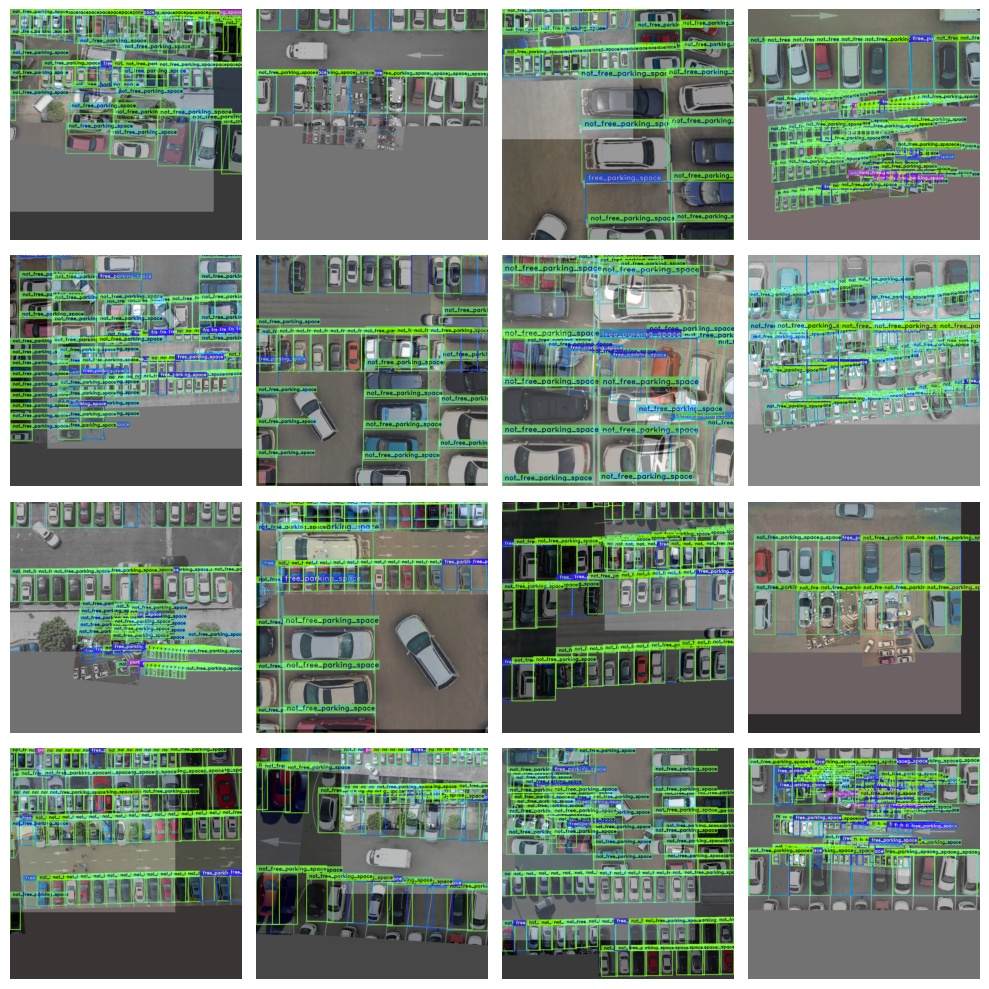

In [ ]:
# Creating the dataset
# Split the datat into train, test, and validation sets
# The training dataset
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

# The validation data set
val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

# The test data set
test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

train_data.dataset.plot() # Visualize the test images with plotting




In [111]:
# Create the trainer
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

# Define the post prediction callback
post_prediction_callback = PPYoloEPostPredictionCallback(
    score_threshold=0.05,    
    nms_threshold=0.7,      
    nms_top_k=300,          
    max_predictions=100      # maximum predictions per image
)

# Define the training parameters
train_params = {
    "max_epochs": 2,          
    "early_stopping_patience": 2,  # if no val improvement for 5 epochs, stop
    "initial_lr": 1e-5,
    "optimizer": "AdamW",
    "zero_weight_decay_on_bias_and_bn": True,
    "train_loader": train_data,
    "valid_loader": val_data,
    "loss": PPYoloELoss(num_classes=config.NUM_CLASSES, use_static_assigner=False),
    "metric_to_watch": "mAP@0.50",
    "valid_metrics_list": [
        DetectionMetrics_050(
            num_cls=config.NUM_CLASSES,
            post_prediction_callback=post_prediction_callback
        )
    ],
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-5,
    "warmup_epochs": 3,
    "average_best_models": False,  
}

# Start training
trainer.train(
    model=model,
    training_params=train_params,
    train_loader=train_data,
    valid_loader=val_data
)


[2025-04-29 09:16:15] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20250429_091615_472635`
[2025-04-29 09:16:15] INFO - sg_trainer.py - Checkpoints directory: ./.ipynb_checkpoints\race_number\RUN_20250429_091615_472635
c:\Users\hanna\anaconda3\envs\tf3\lib\site-packages\super_gradients\common\registry\registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
c:\Users\hanna\anaconda3\envs\tf3\lib\site-packages\super_gradients\training\utils\optimizer_utils.py:108: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0

The console stream is now moved to ./.ipynb_checkpoints\race_number\RUN_20250429_091615_472635/console_Apr29_09_16_15.txt


[2025-04-29 09:17:01] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            16         (len(train_set))
    - Batch size per GPU:           4          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             4          (num_gpus * batch_size)
    - Effective Batch size:         4          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         4          (len(train_loader))
    - Gradient updates per epoch:   4          (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_L  (66.91M parameters, 66.91M optimized)
    - Learning Rates and Weight Decays:
      - default: (66.91M parameters). LR: 1e-05 (66.91M parameters) WD: 0.0, (66.91M parameters)

[2025-04-29 09:17:01] INFO - sg_trainer.py - Started training for 2 epochs (0/1)

Train epoch 0:   0%

Train epoch 0:  75%|███████▌  | 3/4 [01:31<00:30, 30.45s/it, PPYoloELoss/loss=3.1, PPYoloELoss/loss_cls=0.755, PPYoloELoss/loss_dfl=1.24, PPYoloELoss/loss_iou=1.11, gpu_mem=0]
[2025-04-29 09:18:33] INFO - sg_trainer.py - 
[MODEL TRAINING EXECUTION HAS BEEN INTERRUPTED]... Please wait until SOFT-TERMINATION process finishes and saves all of the Model Checkpoints and log files before terminating...
[2025-04-29 09:18:33] INFO - sg_trainer.py - For HARD Termination - Stop the process again
[2025-04-29 09:18:33] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


In [108]:
# Evaluate Our Model

# Find the latest run folder inside .ipynb_checkpoints/race_number/
runs = glob.glob('./.ipynb_checkpoints/race_number/RUN_*')
latest_run = max(runs, key=os.path.getmtime)  # Pick the most recent one

# Path to ckpt_best.pth inside that run
checkpoint_path = os.path.join(latest_run, 'ckpt_best.pth')

# Now load the model
model = models.get(
    "yolo_nas_l",
    num_classes=config.NUM_CLASSES,
    checkpoint_path=checkpoint_path
)

model.eval()

YoloNAS_L(
  (backbone): NStageBackbone(
    (stem): YoloNASStem(
      (conv): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        )
        (branch_1x1): Conv2d(3, 48, kernel_size=(1, 1), stride=(2, 2))
        (post_bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (rbr_reparam): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
    )
    (stage1): YoloNASStage(
      (downsample): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=Tr

[2025-04-29 09:10:45] INFO - checkpoint_utils.py - Successfully loaded model weights from ./.ipynb_checkpoints/race_number\RUN_20250429_082801_584816\ckpt_best.pth checkpoint.


Image 0 predictions: torch.Size([34, 6])
Image 1 predictions: torch.Size([35, 6])
Image 2 predictions: torch.Size([28, 6])
Image 3 predictions: torch.Size([33, 6])
Top predicted labels: [] scores: []


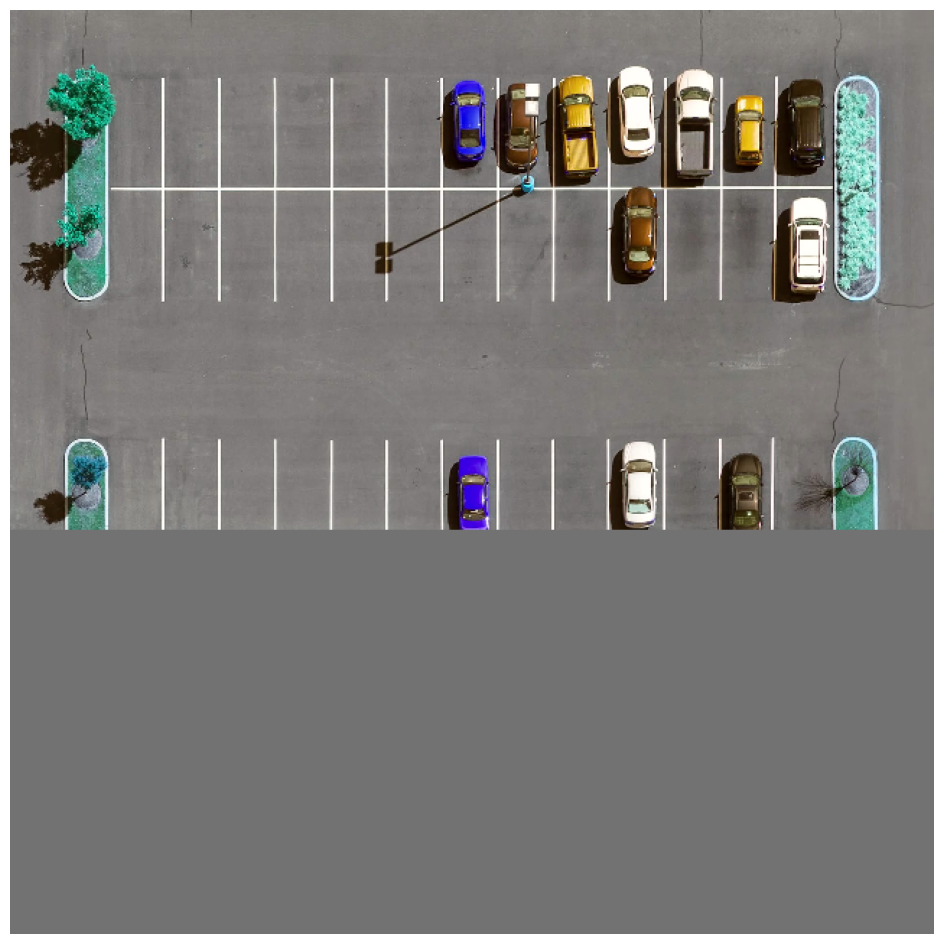

Top predicted labels: [2] scores: [0.03976007]


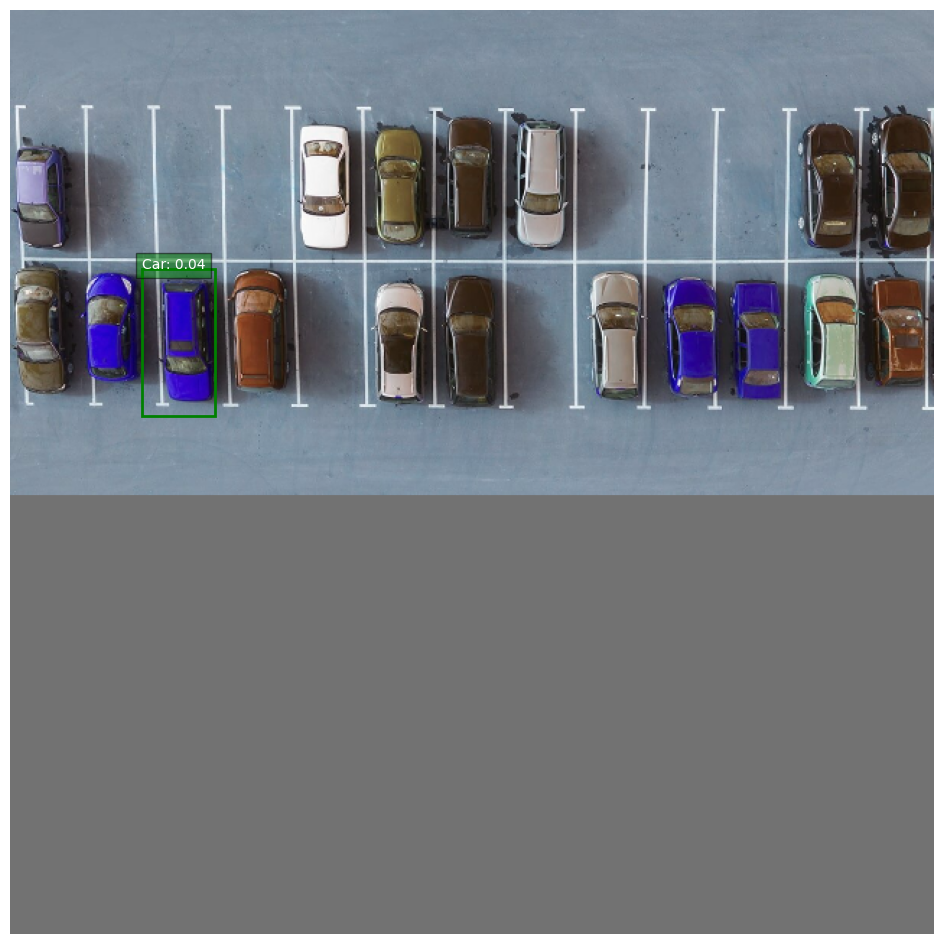

Top predicted labels: [] scores: []


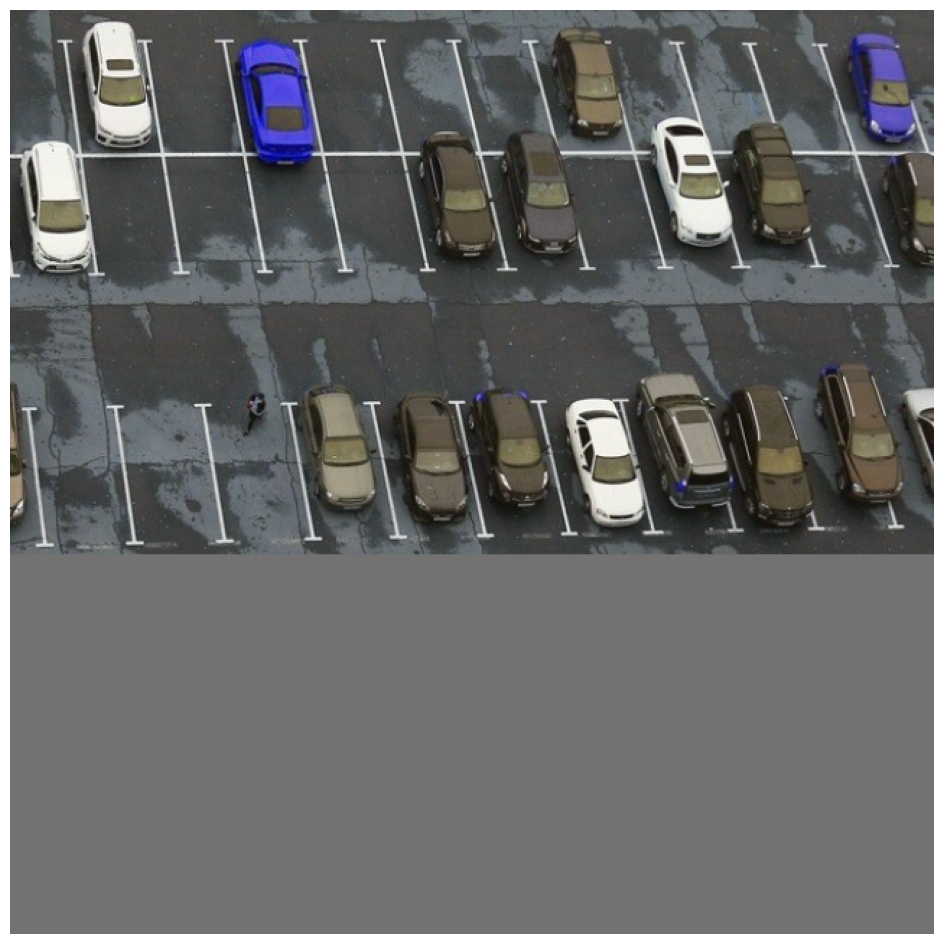

Top predicted labels: [] scores: []


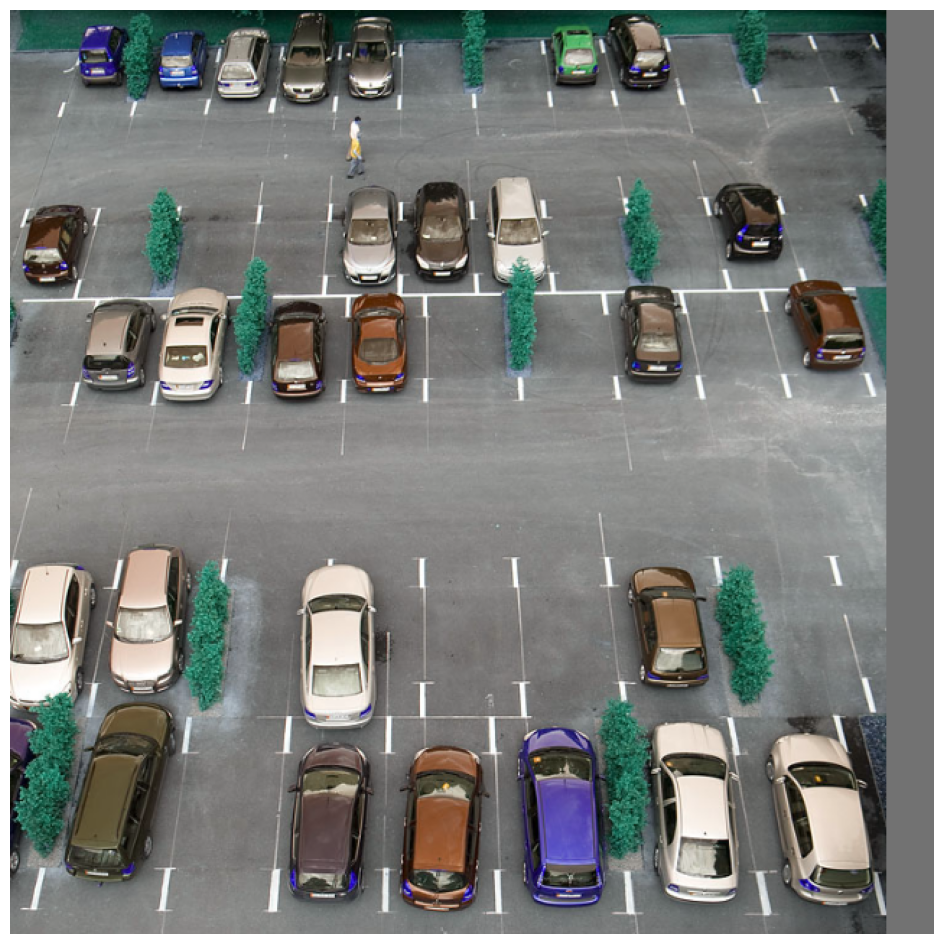

In [112]:
# Draw the Boxes!

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

# COCO classes
COCO_CLASSES = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train",
    "truck", "boat", "traffic light", "fire hydrant", "stop sign", "parking meter",
    "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra",
    "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee",
    "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove",
    "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup",
    "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange",
    "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch",
    "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote",
    "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
]

# 1) Get a batch and run the model
val_images, val_labels = next(iter(val_data))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
with torch.no_grad():
    raw_outputs = model(val_images.to(device))

# 2) Decode with PP-YOLOE post-processing
pp_callback = PPYoloEPostPredictionCallback(
    score_threshold=0.01,
    nms_threshold=0.01,
    max_predictions=5000,
    nms_top_k=2000
)
decoded_outputs = pp_callback(raw_outputs)  # list of [N×6] tensors per image
for i, det in enumerate(decoded_outputs):
    print(f"Image {i} predictions: {det.shape}")  # should be [N, 6] where N > 0


# 3) Build batched boxes_tensor & class_scores_tensor with car filtering
boxes_list, scores_list = [], []
car_class_id = 2  # COCO class ID for 'car'

for det in decoded_outputs:
    if det.numel() == 0:
        # No detections for this image
        boxes_list.append(torch.zeros((0, 4)))
        scores_list.append(torch.zeros((0, len(COCO_CLASSES))))
        continue

    # det shape: [N, 6] => [x1, y1, x2, y2, score, class_id]
    boxes = det[:, :4]
    scores = det[:, 4]
    labels = det[:, 5].long()

    # Keep only cars
    keep = labels == car_class_id
    boxes = boxes[keep]
    scores = scores[keep]
    labels = labels[keep]

    # one-hot encode only car class
    one_hot = torch.zeros((scores.size(0), len(COCO_CLASSES)),
                          device=scores.device)
    one_hot[:, car_class_id] = scores

    boxes_list.append(boxes)
    scores_list.append(one_hot)

# pad each to 8400 rows so we can batch them
max_preds = 8400
boxes_tensor = torch.stack([
    F.pad(b, (0, 0, 0, max_preds - b.size(0))) for b in boxes_list
])
class_scores_tensor = torch.stack([
    F.pad(s, (0, 0, 0, max_preds - s.size(0))) for s in scores_list
])




# 4) Your draw_predictions unchanged
def draw_predictions(image, predictions,
                     car_conf_threshold=0.1,
                     object_conf_threshold=0.1,
                     top_k=1000,
                     bypass_filtering=False):
    image_np = image.permute(1, 2, 0).cpu().numpy()

    if image_np.max() <= 1.0:
        image_np = (image_np * 255).clip(0, 255).astype(np.uint8)
    else:
        image_np = image_np.clip(0, 255).astype(np.uint8)

    H, W, _ = image_np.shape
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(image_np.astype(np.uint8))


    bboxes, class_scores = predictions

    if bboxes.dim() == 3: bboxes = bboxes[0]
    if class_scores.dim() == 3: class_scores = class_scores[0]

    bboxes = bboxes.cpu().numpy()
    class_scores = class_scores.cpu().numpy()

    labels = class_scores.argmax(axis=1)
    scores = class_scores.max(axis=1)

    # keep only valid boxes
    valid = scores > 0
    bboxes, labels, scores = bboxes[valid], labels[valid], scores[valid]

    # keep only top_k by score
    idxs = np.argsort(-scores)[:top_k]
    bboxes, labels, scores = bboxes[idxs], labels[idxs], scores[idxs]

    

    # --------------- Bypass Filtering Mode ---------------
    if bypass_filtering:
        for box, sc, lb in zip(bboxes, scores, labels):
            x1, y1, x2, y2 = np.clip(box, [0, 0, 0, 0], [W, H, W, H])
            if x2 - x1 < 2 or y2 - y1 < 2:
                continue  # skip too small

            name = COCO_CLASSES[lb]
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='orange', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1, f'{name}: {sc:.2f}',
                    bbox=dict(facecolor='orange', alpha=0.5), color='white')

        plt.axis('off')
        plt.grid(True)
        plt.show()
        return
    # ------------------------------------------------------


    # Regular "cars and objects on cars" mode
    car_boxes, other_boxes = [], []
    for box, sc, lb in zip(bboxes, scores, labels):
        if lb == 2 and sc >= car_conf_threshold:
            car_boxes.append((box, sc, lb))
        elif sc >= object_conf_threshold:
            other_boxes.append((box, sc, lb))

    if not car_boxes and not other_boxes:
        # fallback to just showing first few boxes
        for box, sc, lb in zip(bboxes[:5], scores[:5], labels[:5]):
            x1, y1, x2, y2 = np.clip(box, [0, 0, 0, 0], [W, H, W, H])
            if x2 - x1 < 2 or y2 - y1 < 2:
                continue
            name = COCO_CLASSES[lb]
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='blue', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1, f'{name}: {sc:.2f}',
                    bbox=dict(facecolor='blue', alpha=0.5), color='white')
    else:
        # draw cars
        for box, sc, lb in car_boxes:
            x1, y1, x2, y2 = np.clip(box, [0, 0, 0, 0], [W, H, W, H])
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='green', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1, f'Car: {sc:.2f}',
                    bbox=dict(facecolor='green', alpha=0.5), color='white')
        # draw objects on cars
        for box, sc, lb in other_boxes:
            x1, y1, x2, y2 = box
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(W, x2), min(H, y2)
            if x2 - x1 < 1 or y2 - y1 < 1:
                continue

            for cbox, _, _ in car_boxes:
                ix1, iy1 = max(x1, cbox[0]), max(y1, cbox[1])
                ix2, iy2 = min(x2, cbox[2]), min(y2, cbox[3])
                inter = max(0, ix2 - ix1) * max(0, iy2 - iy1)
                area = max(1, (x2 - x1) * (y2 - y1))
                if inter / area > 0.3:
                    name = COCO_CLASSES[lb]
                    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                             linewidth=2, edgecolor='red', facecolor='none')
                    ax.add_patch(rect)
                    ax.text(x1, y1, f'{name}: {sc:.2f}',
                            bbox=dict(facecolor='red', alpha=0.5), color='white')
                    break

    print("Top predicted labels:", labels[:10], "scores:", scores[:100])
    plt.axis('off')
    plt.grid(True)
    plt.show()


# 5) Visualize
for i in range(boxes_tensor.size(0)):
    draw_predictions(val_images[i],
                     (boxes_tensor[i], class_scores_tensor[i]),
                     car_conf_threshold=0.01,
                     object_conf_threshold=0.01,
                     top_k=1000)


In [41]:
# Inspect the decoded outputs to understand its structure
print(decoded_outputs)


[tensor([], size=(0, 6)), tensor([], size=(0, 6)), tensor([], size=(0, 6)), tensor([], size=(0, 6))]


In [21]:
for idx in range(batch_size):
    bbox_pred = boxes_tensor[idx]
    class_scores_pred = class_scores_tensor[idx]
    # Compute probabilities if needed (or leave as is if already probabilities)
    score_values = class_scores_pred.cpu().numpy().max(axis=1)
    print(f"Image {idx} max score: {score_values.max()}")


Image 0 max score: 0.12399663031101227
Image 1 max score: 0.11862047761678696
Image 2 max score: 0.1108311340212822
Image 3 max score: 0.1047443374991417


In [49]:
import os

checkpoint_path = os.path.abspath("../ipynb_checkpoints/race_number/checkpoints/ckpt_best.pth")
print(checkpoint_path)


c:\Users\hanna\AI\ipynb_checkpoints\race_number\checkpoints\ckpt_best.pth


In [30]:

class_scores_tensor = F.softmax(class_scores_tensor, dim=1)

print("After softmax:", class_scores_tensor[0][0].cpu().numpy())

print(len(config.CLASSES))

# Check top predictions
topk_scores, topk_labels = class_scores_tensor[0].topk(5)

print("Top predicted labels:", topk_labels)
print("Corresponding scores:", topk_scores)


After softmax: [0.00011905 0.00011905 0.00011905 0.00011905 0.00011905 0.00011905
 0.00011905 0.00011905 0.00011905 0.00011905 0.00011905 0.00011905
 0.00011905 0.00011905 0.00011905 0.00011905 0.00011905 0.00011905
 0.00011905 0.00011905 0.00011905 0.00011905 0.00011905 0.00011905
 0.00011905 0.00011905 0.00011905 0.00011905 0.00011905 0.00011905
 0.00011905 0.00011905 0.00011905 0.00011905 0.00011905 0.00011905
 0.00011905 0.00011905 0.00011905 0.00011905 0.00011905 0.00011905
 0.00011905 0.00011905 0.00011905 0.00011905 0.00011905 0.00011905
 0.00011905 0.00011905 0.00011905 0.00011905 0.00011905 0.00011905
 0.00011905 0.00011905 0.00011905 0.00011905 0.00011905 0.00011905
 0.00011905 0.00011905 0.00011905 0.00011905 0.00011905 0.00011905
 0.00011905 0.00011905]
3
Top predicted labels: tensor([[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        ...,
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4]])
Corresponding scores: tensor([[0.000